# Sales Forecasting 

## Define 

The shampoo sales dataset used in this project can be obtained from Kaggle or from https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv. 

The data has sales numbers for three consecutive years. Forecasting the sales with respect to time is helpful for any organization in anticipating the Revenue growth.

Revenue forecats aids organizations and help them bring new investors, generate budgets and manage/maintain cashflows. 

Objective:
    
Forecast shampoo sales for any given period.

In [1]:
#importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

__author__ = "Sai Jyothi Gurram"
__email__ = "jyothisai1993@gmail.com"

all necessary libraries have been imported 

## Discover

## Loading the Data 

In [4]:
#loading data as dataframe
data = pd.read_csv('shampoo sales.csv')
print (data.head())
print (data.dtypes)

   Month  Sales
0  1-Jan  266.0
1  1-Feb  145.9
2  1-Mar  183.1
3  1-Apr  119.3
4  1-May  180.3
Month     object
Sales    float64
dtype: object


## Cleaning the Data 

In [5]:
#checking null values in the dataset 
print(data.isnull().any())

Month    False
Sales    False
dtype: bool


there are no null values in the dataset

In [6]:
#setting the month as index 
data = data.set_index('Month')
print (data.head())

       Sales
Month       
1-Jan  266.0
1-Feb  145.9
1-Mar  183.1
1-Apr  119.3
1-May  180.3


## Data Exploration 

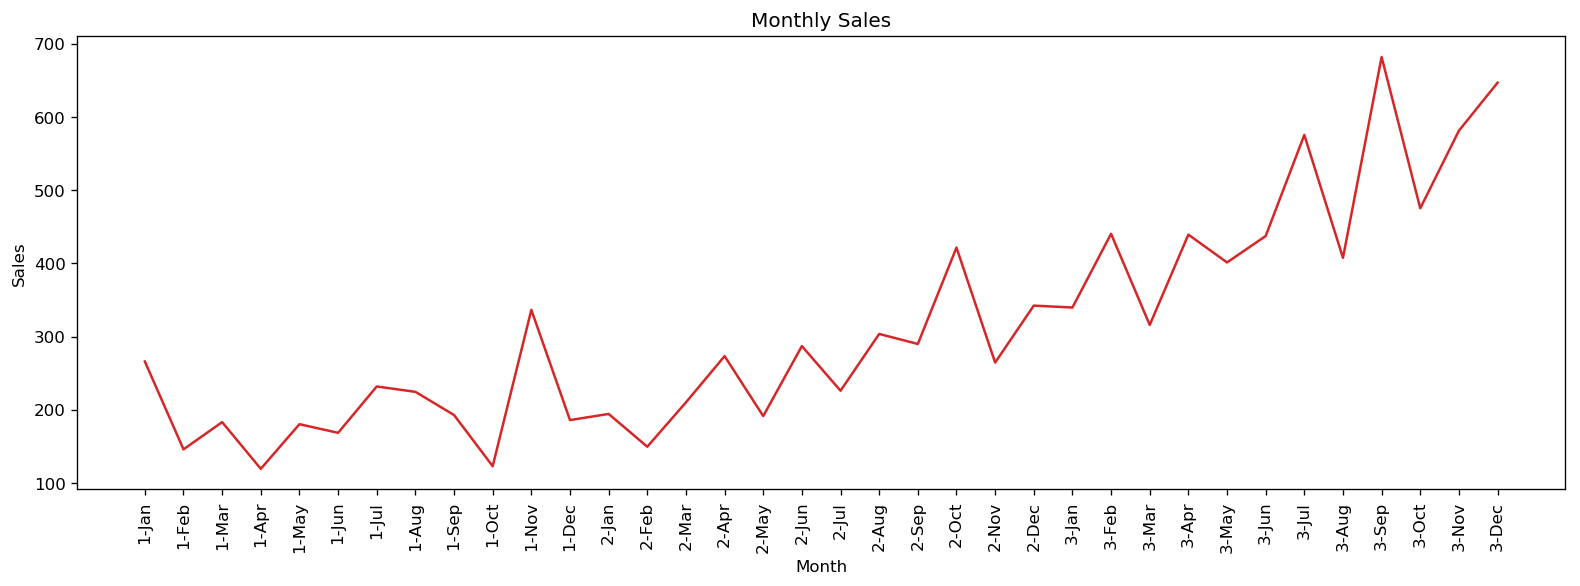

In [7]:
#creating function to plot the time series data
def plot(df, x, y, title="", xlabel='', ylabel='', dpi=120):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xticks(rotation=90)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot(data, x=data.index, y=data.Sales, title='Monthly Sales',xlabel = 'Month',ylabel = 'Sales')    

can clearly see trend and seasonality 

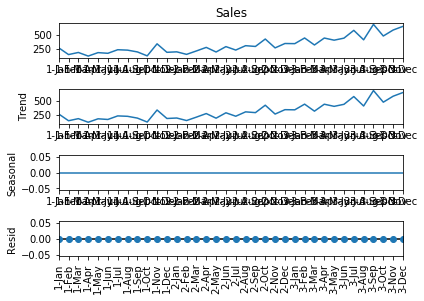

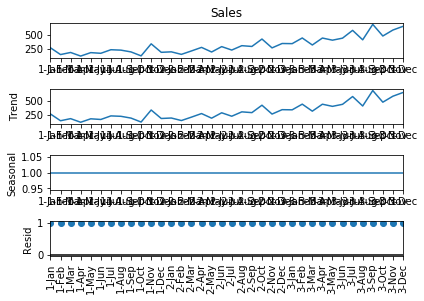

In [17]:
#using seasonal decompose to understand the trend and seasonality

result = seasonal_decompose(data.Sales, model='additive', period = 1)

#draw plot
result.plot()
plt.xticks(rotation=90)
plt.show()

#using multiplicate model as well to check 
result = seasonal_decompose(data.Sales, model='muliplicative', period = 1)

#draw plot
result.plot()
plt.xticks(rotation=90)
plt.show()

Based on the plot there is no difference between additive and mutiplicative model. Also, there is no seasonality but can identify trend 

verifying whether the data is stationary or not. 

Using augmented dickey fuller test and exponential smoothing (rolling method) to check. 

In [9]:
#creating function to test stationarity
def stationarity(df):
    
    #Rolling mean and standard deviation 
    mean_r = df.rolling(6).mean()
    std_r = df.rolling(6).std()

    #Rolling mean, standard deviation and differenced plot
    actual = plt.plot(df, color='black',label='Actual')
    mean = plt.plot(mean_r, color='red', label='Rolling Mean')
    std = plt.plot(std_r, color='green', label = 'Rolling Std')
    plt.xticks(rotation = 90)
    plt.legend(loc='best')
    plt.title('stationarity plot')
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    df_test = adfuller(df, autolag='AIC')
    dfResults = pd.Series(df_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in df_test[4].items():
        dfResults['Critical Value (%s)'%key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)
    

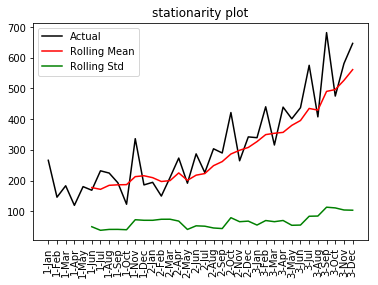

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       3.060142
P-Value                  1.000000
# Lags Used             10.000000
# Observations Used     25.000000
Critical Value (1%)     -3.723863
Critical Value (5%)     -2.986489
Critical Value (10%)    -2.632800
dtype: float64


In [11]:
#checking stationarity of the data 
stationarity(data)

clearly there is an upward trend and the standard deviation is also not stationary 

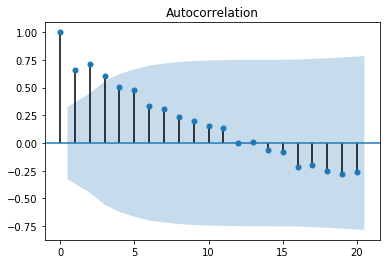

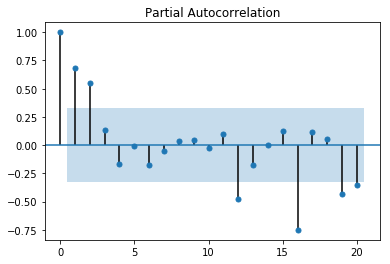

In [12]:
#understanding autocorrelation and partial auto correlations

plot_acf(data,lags=20)
plt.show()
plot_pacf(data,lags = 20)
plt.show()

the p value can be obtained from partial autocorelation plot - Here it indicates that the lags are correlated until 3
the q value can be obtained from autocorrelation plot - Here it indicates that the lag errors are correlated until 4 lags 

Time series cannot be applied on non-stationary data so using first order differencing to make it stationary

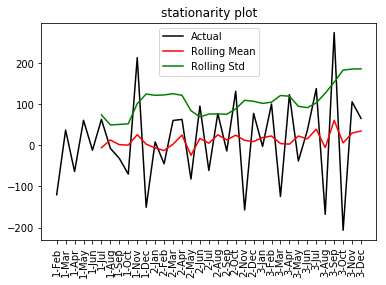

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.249074e+00
P-Value                 1.799857e-10
# Lags Used             1.000000e+00
# Observations Used     3.300000e+01
Critical Value (1%)    -3.646135e+00
Critical Value (5%)    -2.954127e+00
Critical Value (10%)   -2.615968e+00
dtype: float64


In [13]:
#first order differencing 
ts_diff = data - data.shift()

#checking stationarity 
stationarity(ts_diff.dropna())

As the p value is less than 0.05 we can reject our null hypothesis and confirm that the data is stationary after 1st differencing 

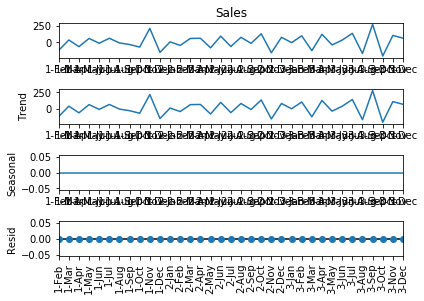

In [14]:
#plotting seasonal decompose to check the stationarity 
result = seasonal_decompose(ts_diff.Sales.dropna(), model='additive', period = 1)
#draw plot
result.plot()
plt.xticks(rotation=90)
plt.show()

the trend decomposition also indicates there is no trend in the data 

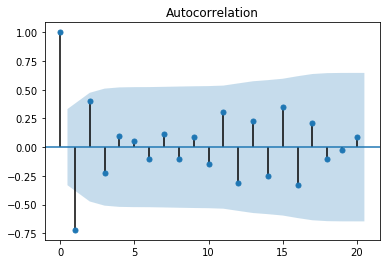

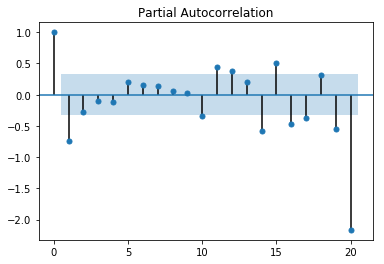

In [15]:
#understanding autocorrelation and partial auto correlations for 1st order difference data 
plot_acf(ts_diff.dropna(),lags = 20)
plt.show()
plot_pacf(ts_diff.dropna(),lags = 20)
plt.show()

based on the acf and pacf plots the p value and q value is 2 

## Creating Baseline Model 

In [18]:
#dividing data into train and test
train, test = data[0:30], data[30:]

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   29
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -157.199
Method:                       css-mle   S.D. of innovations             46.642
Date:                Wed, 06 May 2020   AIC                            332.399
Time:                        10:37:58   BIC                            344.704
Sample:                             1   HQIC                           336.253
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8598      6.060      1.297      0.195      -4.018      19.737
ar.L1.D.Sales    -0.9931      0.273     -3.633      0.000      -1.529      -0.457
ar.L2.D.Sales    -0.6811      0.286     

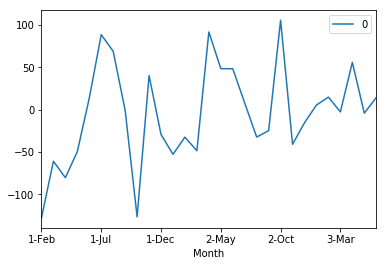

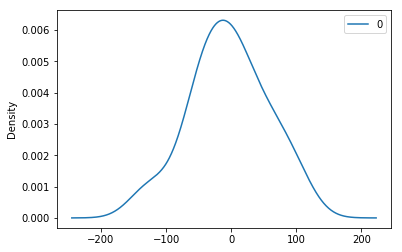

                0
count   29.000000
mean    -4.310384
std     59.035027
min   -127.959750
25%    -40.940754
50%     -2.594903
75%     40.259081
max    105.738997


In [19]:
# fit a base model just for comparision  

model = ARIMA(train, order=(3,1,4))
model_fit = model.fit(disp= -1)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

The value of AIC IS 332 and the coefficients of the terms are small. There is still slight trend in the residuals. 

Predicting the sales over test set 

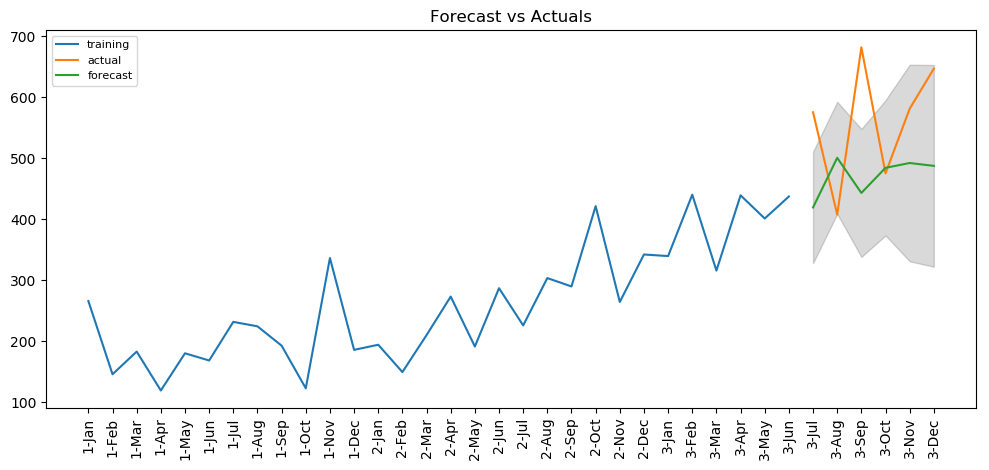

In [20]:
# Forecast
fc, se, confidence = model_fit.forecast(6, alpha=0.05)  

#with 95% confidence 

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_limit = pd.Series(confidence[:, 0], index=test.index)
upper_limit = pd.Series(confidence[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_limit.index, lower_limit, upper_limit, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation = 90)
plt.show()

The predicted values are aligned with the train set but the model couldn't capture the peaks. 

In [21]:
# Accuracy metrics
fc = list(fc)

#root mean sqaure error 
rmse = np.mean((fc - test.Sales)**2)**.5  

#mean absolute error
mae = np.mean(np.abs(fc - test.Sales)) 
mape = np.mean(np.abs(fc - test.Sales)/np.abs(test.Sales))  # MAPE
print('rmse:',rmse)
print('mae:',mae)
print('mape:',mape)

rmse: 143.43770820934915
mae: 124.24689302753298
mape: 0.21142003760370276


the mape value indicates that the model was able to predict 79% of the variance. 

In [22]:
#writing a loop to loop over p,d,q values

for p in range(5):
    for q in range(5):
        
        from statsmodels.tsa.arima_model import ARIMA
        model = ARIMA(train,order = (p,1,q))
        model_fit = model.fit(disp= -1)
 
        
        # Forecast
        fc, se, conf = model_fit.forecast(6, alpha=0.05)  # 95% conf

        #mean absolute percentage error 
        mape = np.mean(np.abs(fc - test.Sales)/np.abs(test.Sales))  # MAPE
        
        #ignoring warnings 
        
        import warnings
        warnings.filterwarnings('ignore')
        
        #printing the values 
        print('p value:',p,'q value:',q,'mape:',mape)
     

p value: 0 q value: 0 mape: 0.19336726790612144
p value: 0 q value: 1 mape: 0.214430371583994
p value: 0 q value: 2 mape: 0.19762475984155037
p value: 0 q value: 3 mape: 0.19708281716451917
p value: 0 q value: 4 mape: 0.19623068438347582
p value: 1 q value: 0 mape: 0.20401158701370514
p value: 1 q value: 1 mape: 0.20536424867447992
p value: 1 q value: 2 mape: 0.17992955884749093
p value: 1 q value: 3 mape: 0.17980481852607388
p value: 1 q value: 4 mape: 0.21037766347462447
p value: 2 q value: 0 mape: 0.1986232161889788
p value: 2 q value: 1 mape: 0.2338783251413348
p value: 2 q value: 2 mape: 0.24585744953508012
p value: 2 q value: 3 mape: 0.20788144745080797
p value: 2 q value: 4 mape: 0.21044958484915496
p value: 3 q value: 0 mape: 0.22385259964038307
p value: 3 q value: 1 mape: 0.2180572859616272
p value: 3 q value: 2 mape: 0.18946704828647123
p value: 3 q value: 3 mape: 0.18999595728334573
p value: 3 q value: 4 mape: 0.21142003760370276
p value: 4 q value: 0 mape: 0.216688874142071

p value 1 and q value 3 and  d = 1 has the least mape error  

## Final Model 

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   29
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -159.935
Method:                       css-mle   S.D. of innovations             54.480
Date:                Wed, 06 May 2020   AIC                            331.870
Time:                        10:45:28   BIC                            340.074
Sample:                             1   HQIC                           334.439
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.2129      6.947      1.038      0.299      -6.404      20.829
ar.L1.D.Sales     0.0209      0.503      0.042      0.967      -0.964       1.006
ma.L1.D.Sales    -1.2397      0.478     

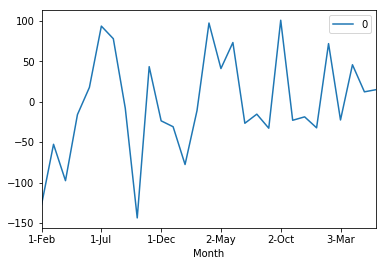

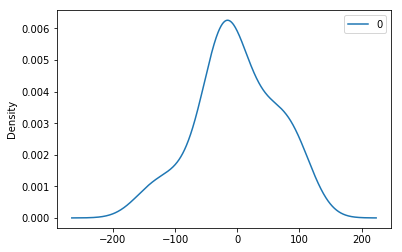

                0
count   29.000000
mean    -2.324516
std     63.554426
min   -143.866971
25%    -30.889186
50%    -15.322186
75%     43.505482
max    101.037865


In [24]:
#building the final model 

model = ARIMA(train,order = (1,1,3))
model_fit = model.fit(disp= -1)
print(model_fit.summary())
        
# Forecast
fc, se, conf = model_fit.forecast(6, alpha=0.05)  # 95% conf

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

The AIC value is less than the base model. The mean is better the base model and the trend in residuals has reduced 

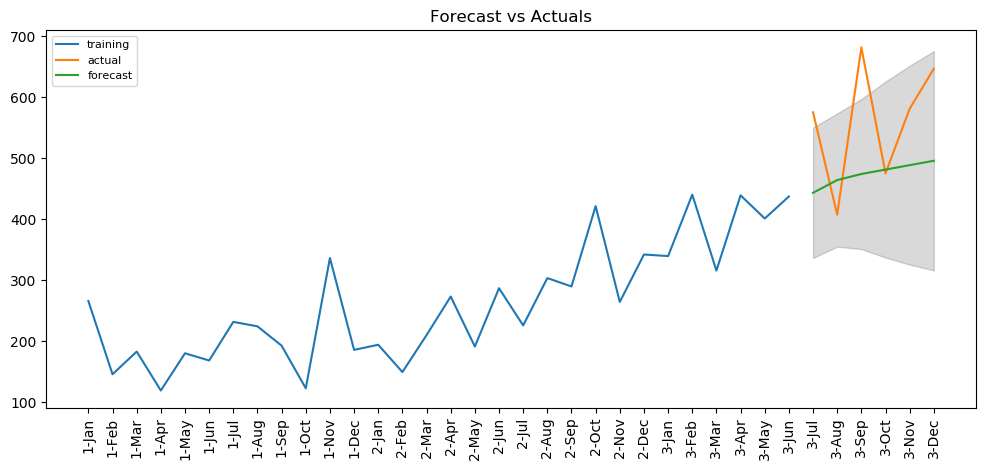

In [25]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_limit = pd.Series(conf[:, 0], index=test.index)
upper_limit = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_limit.index, lower_limit, upper_limit, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation = 90)
plt.show()

the model developed predicts 83% of the expected values according to the mape error. 

## Six Month Forecast 

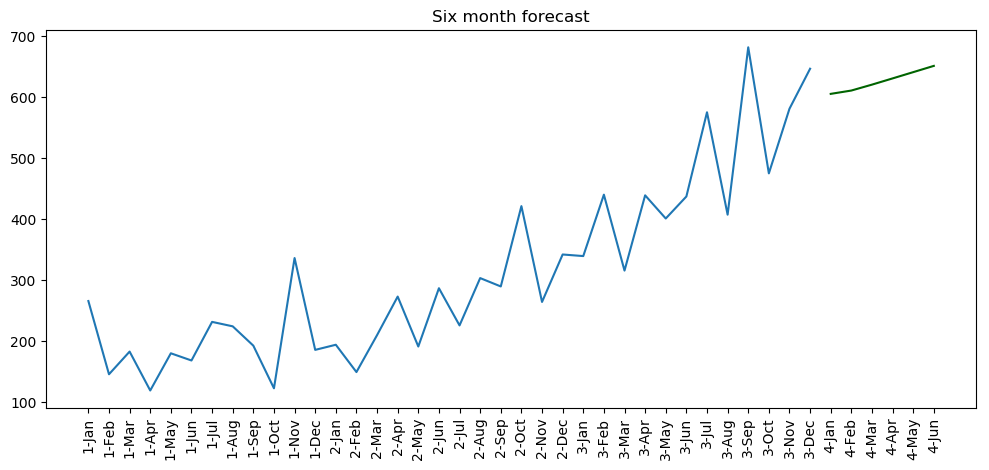

In [26]:
#predicting shampoo sales for the next 6 months 
model = ARIMA(data,order = (1,1,3))
model_fit = model.fit(disp= -1)
        
# Forecast
fc, se, confint = model_fit.forecast(6, alpha=0.05)  # 95% conf
index_of_fc = ['4-Jan','4-Feb','4-Mar','4-Apr','4-May','4-Jun']

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data.Sales)
plt.plot(fc_series, color='darkgreen')
plt.xticks(rotation = 90)
plt.title("Six month forecast")
plt.show()


Summary: 
    
As the size of the dataset increases the model should be trained again to decipher all the patterns and forecast future purchases. 

Areas of Improvement:
    
Other exponential smoothing techniques can be used to further reduce the mape error and reduce trend in the residuals. 